In [1]:
import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
from tqdm import tqdm
import matplotlib.pyplot as plt

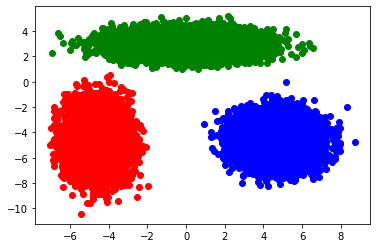

In [2]:
n = 10000

scale = 3 
mu1 = scale*np.array([-1.5396,-1.5396])
sigma1 = np.array([[0.5,0],[0,2]])

mu2 = scale*np.array([0,1])
sigma2 = np.array([[3,0],[0,1/3]])

mu3 = scale*np.array([1.5396,-1.5396])
sigma3 = np.array([[1,0],[0,1]])

x1 = np.random.multivariate_normal(mean = mu1, cov = sigma1, size = n)
y1 = np.array([[1.0,0.0,0.0] for i in range(n)])

x2 = np.random.multivariate_normal(mean = mu2, cov = sigma2, size = n)
y2 = np.array([[0.0,1.0,0.0] for i in range(n)])

x3 = np.random.multivariate_normal(mean = mu3, cov = sigma3, size = n)
y3 = np.array([[0.0,0.0,1.0] for i in range(n)])


X = np.concatenate([x1,x2,x3])
Y = np.concatenate([y1,y2,y3])

plt.scatter(x1[:,0],x1[:,1], c = "red")
plt.scatter(x2[:,0],x2[:,1], c = "green")
plt.scatter(x3[:,0],x3[:,1], c = "blue")
plt.show()

In [3]:
def make_preturb_data(data, noise_peterb=10**0):
    preturb_data = data+np.random.normal(scale=noise_peterb,size=data.shape)
    return preturb_data

def preturb_X(x1, x2, x3):
  x1_aug = make_preturb_data(x1)

  x2_aug = make_preturb_data(x2)

  x3_aug = make_preturb_data(x3)

  X_aug = np.concatenate([x1_aug,x2_aug,x3_aug])
  X_aug = X_aug/np.abs(X_aug).max(axis = 0)
  plt.scatter(x1_aug[:,0],x1_aug[:,1], c = "red")
  plt.scatter(x2_aug[:,0],x2_aug[:,1], c = "green")
  plt.scatter(x3_aug[:,0],x3_aug[:,1], c = "blue")
  plt.show()
  return X_aug

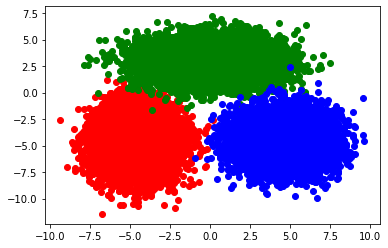

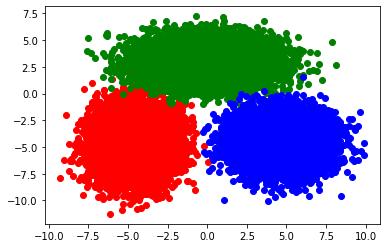

In [4]:
x_aug1 = preturb_X(x1, x2, x3)
x_aug2 = preturb_X(x1, x2, x3)

In [5]:
x1 = tf.data.Dataset.from_tensor_slices(x_aug1)
x2 = tf.data.Dataset.from_tensor_slices(x_aug2)
y =  tf.data.Dataset.from_tensor_slices(Y)

In [6]:
def tf_unif_prior_crossentropy(pred1,pred2):
    N, C = pred1.shape 
    
    t_c = 0.1
    t_r = 0.1
    
    a = tf.nn.softmax(pred2/t_c, axis=0)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part11 = c
    d = tf.nn.softmax(pred1/t_r, axis=1)
    part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
    loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)
    
    a = tf.nn.softmax(pred1/t_c)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part12 = c
    d = tf.nn.softmax(pred2/t_r, axis=1)
    part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
    loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

    return tf.math.reduce_mean(1/2*(loss_1+loss_2))


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2), dtype=tf.float32),
    tf.keras.layers.Dense(units=32, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=3)])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

NUM_EPOCHS = 10
EPOCH_PER_DISPLAY = 1
total_loss = []
train_dataset = tf.data.Dataset.from_tensor_slices((x_aug1, x_aug2, Y))
train_dataset = train_dataset.shuffle(30000).batch(1000)

for epoch in range(NUM_EPOCHS):

  running_loss = []

  for input1, input2, target in train_dataset:
    with tf.GradientTape() as tape:

      pred1 = model(input1, training=True)
      pred2 = model(input2, training=True)

      loss_ = tf_unif_prior_crossentropy(pred1, pred2)

      grads = tape.gradient(loss_, model.trainable_variables)
      
    running_loss.append(loss_)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  epoch_loss = np.mean(running_loss)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Loss: {:.4f}".format(epoch+1, epoch_loss))

Epoch 1: Loss: 0.8457
Epoch 2: Loss: 0.5665
Epoch 3: Loss: 0.2414
Epoch 4: Loss: 0.0980
Epoch 5: Loss: 0.0682
Epoch 6: Loss: 0.0565
Epoch 7: Loss: 0.0494
Epoch 8: Loss: 0.0449
Epoch 9: Loss: 0.0420
Epoch 10: Loss: 0.0398


In [2]:
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

In [15]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

In [24]:
model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [23]:
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for e in range(num_epochs):
  for batch_index in tqdm(range(num_batches)):
      X1, X2, y = data_loader.get_batch(batch_size)
      with tf.GradientTape() as tape:
          y_pred = model(X)
          loss = newLoss(y_true=y, y_pred=y_pred)
          loss = tf.reduce_mean(loss)
          # print("batch %d: loss %f" % (batch_index, loss.numpy()))
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

  0%|          | 0/600 [00:00<?, ?it/s]


TypeError: ignored

In [14]:
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)

print("test accuracy: %f" % sparse_categorical_accuracy.result())

16/16 [==============================] - 0s 2ms/step
test accuracy: 0.978700
